In [1]:

# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)




In [2]:

# Step 1: Download and Load the Dataset

# Load the dataset
data_dir = "/kaggle/input/fashion-product-images-dataset/fashion-dataset"
images_dir = os.path.join(data_dir, "images")
styles_file = os.path.join(data_dir, "styles.csv")

# Load the CSV file
df = pd.read_csv(styles_file, on_bad_lines='skip')
print(df.head())


      id gender masterCategory subCategory  articleType baseColour  season  \
0  15970    Men        Apparel     Topwear       Shirts  Navy Blue    Fall   
1  39386    Men        Apparel  Bottomwear        Jeans       Blue  Summer   
2  59263  Women    Accessories     Watches      Watches     Silver  Winter   
3  21379    Men        Apparel  Bottomwear  Track Pants      Black    Fall   
4  53759    Men        Apparel     Topwear      Tshirts       Grey  Summer   

     year   usage                             productDisplayName  
0  2011.0  Casual               Turtle Check Men Navy Blue Shirt  
1  2012.0  Casual             Peter England Men Party Blue Jeans  
2  2016.0  Casual                       Titan Women Silver Watch  
3  2011.0  Casual  Manchester United Men Solid Black Track Pants  
4  2012.0  Casual                          Puma Men Grey T-shirt  


Missing values in the dataset:
id                      0
gender                  0
masterCategory          0
subCategory             0
articleType             0
baseColour             15
season                 21
year                    1
usage                 317
productDisplayName      7
dtype: int64


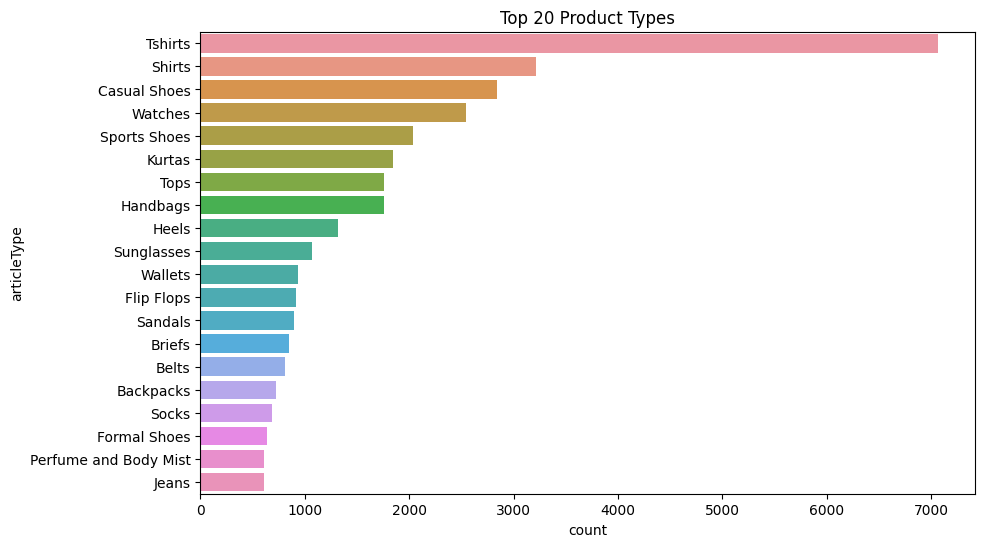

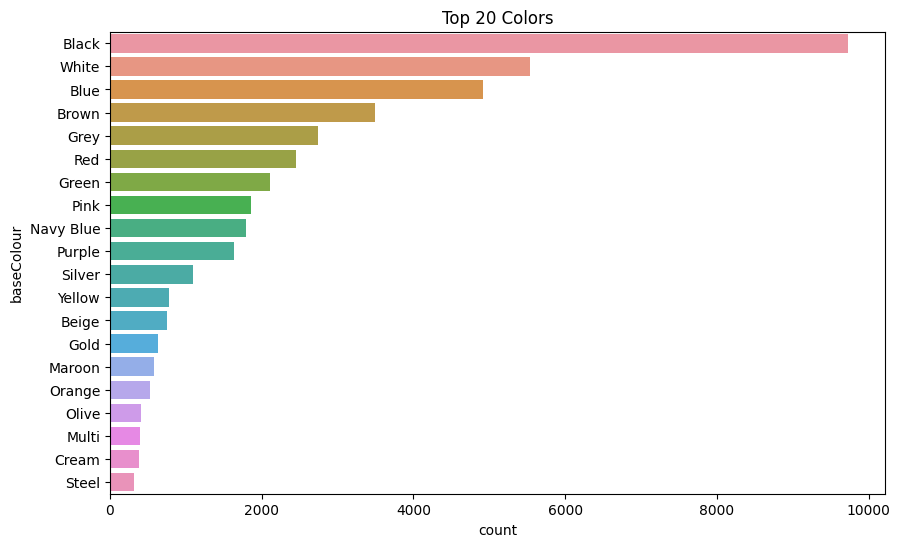

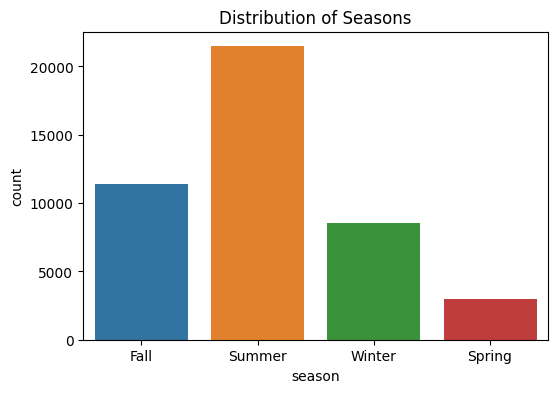

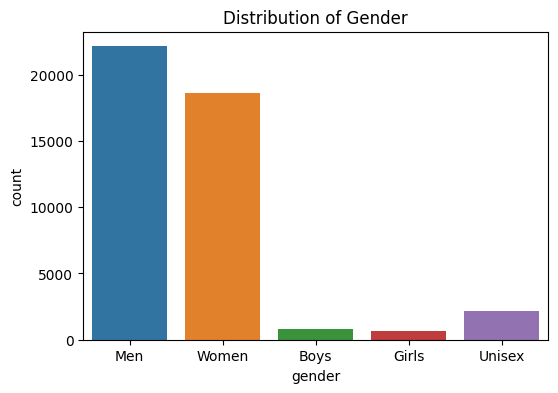

In [3]:

# Step 2: Exploratory Data Analysis (EDA)
# Check for missing values
print("Missing values in the dataset:")
print(df.isnull().sum())

# Check the distribution of product types
plt.figure(figsize=(10, 6))
sns.countplot(y='articleType', data=df, order=df['articleType'].value_counts().index[:20])
plt.title("Top 20 Product Types")
plt.show()

# Check the distribution of colors
plt.figure(figsize=(10, 6))
sns.countplot(y='baseColour', data=df, order=df['baseColour'].value_counts().index[:20])
plt.title("Top 20 Colors")
plt.show()

# Check the distribution of seasons
plt.figure(figsize=(6, 4))
sns.countplot(x='season', data=df)
plt.title("Distribution of Seasons")
plt.show()

# Check the distribution of gender
plt.figure(figsize=(6, 4))
sns.countplot(x='gender', data=df)
plt.title("Distribution of Gender")
plt.show()

In [4]:

# Step 3: Preprocess the Data
# Filter out rows with missing image files
df['image_path'] = df['id'].apply(lambda x: os.path.join(images_dir, f"{x}.jpg"))
df = df[df['image_path'].apply(os.path.exists)]

# Encode categorical labels
label_encoders = {}
for column in ['articleType', 'baseColour', 'season', 'gender']:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

# Split the dataset into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

In [5]:
# Step 4: Create Data Generators
# Define image size and batch size
img_size = (224, 224)
batch_size = 32

# Create ImageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col=['articleType', 'baseColour', 'season', 'gender'],
    target_size=img_size,
    batch_size=batch_size,
    class_mode='multi_output'
)


val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='image_path',
    y_col=['articleType', 'baseColour', 'season', 'gender'],
    target_size=img_size,
    batch_size=batch_size,
    class_mode='multi_output'
)

Found 35535 validated image filenames.
Found 8884 validated image filenames.


In [6]:
from tensorflow.keras.utils import to_categorical, Sequence  
import numpy as np
import os
import tensorflow as tf

class MultiOutputDataGenerator(Sequence):
    def __init__(self, dataframe, x_col, y_col, image_dir, batch_size, img_size, num_classes, shuffle=True):
        self.dataframe = dataframe
        self.x_col = x_col
        self.y_col = y_col
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.img_size = img_size
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.dataframe))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return int(np.ceil(len(self.dataframe) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_x = []
        batch_y = {col: [] for col in self.y_col}
        
        for i in batch_indexes:
            row = self.dataframe.iloc[i]
            img_path = os.path.join(self.image_dir, row[self.x_col])
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=self.img_size)
            img = tf.keras.preprocessing.image.img_to_array(img) / 255.0
            batch_x.append(img)
            
            for col in self.y_col:
                # One-hot encode the labels
                label = row[col]
                one_hot_label = to_categorical(label, num_classes=self.num_classes[col])
                batch_y[col].append(one_hot_label)
        
        batch_x = np.array(batch_x)
        for col in self.y_col:
            batch_y[col] = np.array(batch_y[col])
        
        return batch_x, batch_y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

In [7]:
# Number of classes for each task
num_classes = {
    'articleType': len(label_encoders['articleType'].classes_),
    'baseColour': len(label_encoders['baseColour'].classes_),
    'season': len(label_encoders['season'].classes_),
    'gender': len(label_encoders['gender'].classes_)
}

# Create custom data generators
train_generator = MultiOutputDataGenerator(
    dataframe=train_df,
    x_col='image_path',
    y_col=['articleType', 'baseColour', 'season', 'gender'],
    image_dir=images_dir,
    batch_size=batch_size,
    img_size=img_size,
    num_classes=num_classes,
    shuffle=True
)

val_generator = MultiOutputDataGenerator(
    dataframe=val_df,
    x_col='image_path',
    y_col=['articleType', 'baseColour', 'season', 'gender'],
    image_dir=images_dir,
    batch_size=batch_size,
    img_size=img_size,
    num_classes=num_classes,
    shuffle=False
)

In [8]:
# Check the output shapes of the generators
batch_x, batch_y = train_generator[0]
print("Batch X shape:", batch_x.shape)
for col in batch_y:
    print(f"Batch Y ({col}) shape:", batch_y[col].shape)

Batch X shape: (32, 224, 224, 3)
Batch Y (articleType) shape: (32, 142)
Batch Y (baseColour) shape: (32, 47)
Batch Y (season) shape: (32, 5)
Batch Y (gender) shape: (32, 5)


In [9]:

# Step 5: Build the Multi-Task Deep Learning Model
# Load MobileNetV2 as the base model
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)

# Define output layers for each task
output_articleType = Dense(len(label_encoders['articleType'].classes_), activation='softmax', name='articleType')(x)
output_baseColour = Dense(len(label_encoders['baseColour'].classes_), activation='softmax', name='baseColour')(x)
output_season = Dense(len(label_encoders['season'].classes_), activation='softmax', name='season')(x)
output_gender = Dense(len(label_encoders['gender'].classes_), activation='softmax', name='gender')(x)

# Combine the model
model = Model(inputs=base_model.input, outputs=[output_articleType, output_baseColour, output_season, output_gender])
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss={'articleType': 'categorical_crossentropy',
                    'baseColour': 'categorical_crossentropy',
                    'season': 'categorical_crossentropy',
                    'gender': 'categorical_crossentropy'},
              metrics={'articleType': 'accuracy',
                       'baseColour': 'accuracy',
                       'season': 'accuracy',
                       'gender': 'accuracy'})

# Print model summary
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 3,773,703 (14.40 MB)

 Trainable params: 1,515,719 (5.78 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [10]:
epochs = 10
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=epochs
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1111/1111 ━━━━━━━━━━━━━━━━━━━━ 1070s 945ms/step - articleType_accuracy: 0.5355 - articleType_loss: 2.1357 - baseColour_accuracy: 0.2826 - baseColour_loss: 2.6484 - gender_accuracy: 0.3085 - gender_loss: 0.9800 - loss: 6.4325 - season_accuracy: 0.2662 - season_loss: 0.6684 - val_articleType_accuracy: 0.7804 - val_articleType_loss: 0.8263 - val_baseColour_accuracy: 0.4544 - val_baseColour_loss: 1.9546 - val_gender_accuracy: 0.2716 - val_gender_loss: 0.7501 - val_loss: 3.9070 - val_season_accuracy: 0.2626 - val_season_loss: 0.3753
Epoch 2/10
1111/1111 ━━━━━━━━━━━━━━━━━━━━ 0s 55us/step - articleType_accuracy: 0.0000e+00 - articleType_loss: 0.0000e+00 - baseColour_accuracy: 0.0000e+00 - baseColour_loss: 0.0000e+00 - gender_accuracy: 0.0000e+00 - gender_loss: 0.0000e+00 - loss: 0.0000e+00 - season_accuracy: 0.0000e+00 - season_loss: 0.0000e+00
Epoch 3/10


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1111/1111 ━━━━━━━━━━━━━━━━━━━━ 767s 687ms/step - articleType_accuracy: 0.7717 - articleType_loss: 0.8492 - baseColour_accuracy: 0.4220 - baseColour_loss: 2.0311 - gender_accuracy: 0.2882 - gender_loss: 0.7920 - loss: 4.0907 - season_accuracy: 0.2617 - season_loss: 0.4184 - val_articleType_accuracy: 0.8115 - val_articleType_loss: 0.6623 - val_baseColour_accuracy: 0.4849 - val_baseColour_loss: 1.8130 - val_gender_accuracy: 0.3020 - val_gender_loss: 0.7227 - val_loss: 3.5389 - val_season_accuracy: 0.2583 - val_season_loss: 0.3400
Epoch 4/10
1111/1111 ━━━━━━━━━━━━━━━━━━━━ 0s 25us/step - articleType_accuracy: 0.0000e+00 - articleType_loss: 0.0000e+00 - baseColour_accuracy: 0.0000e+00 - baseColour_loss: 0.0000e+00 - gender_accuracy: 0.0000e+00 - gender_loss: 0.0000e+00 - loss: 0.0000e+00 - season_accuracy: 0.0000e+00 - season_loss: 0.0000e+00
Epoch 5/10
1111/1111 ━━━━━━━━━━━━━━━━━━━━ 740s 662ms/step - articleType_accuracy: 0.8047 - articleType_loss: 0.6706 - baseColour_accuracy: 0.4625 - bas

In [11]:
# Step 7: Save the Model
model.save("fashion_product_model.h5")

In [12]:
from IPython.display import FileLink

# Create a download link
FileLink("fashion_product_model.h5")

/kaggle/working/fashion_product_model.h5

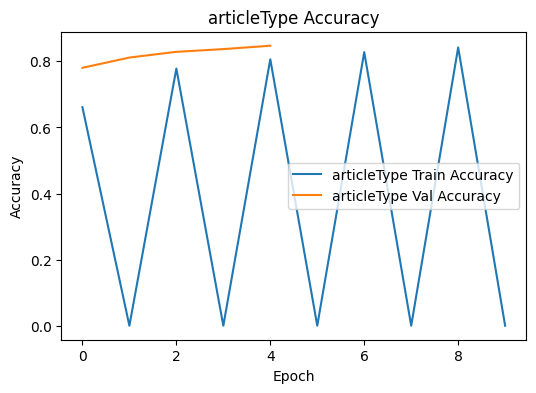

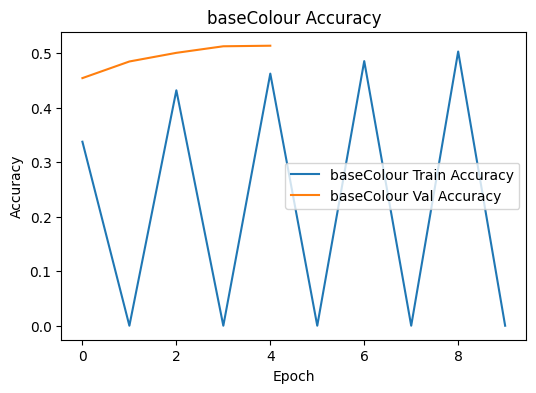

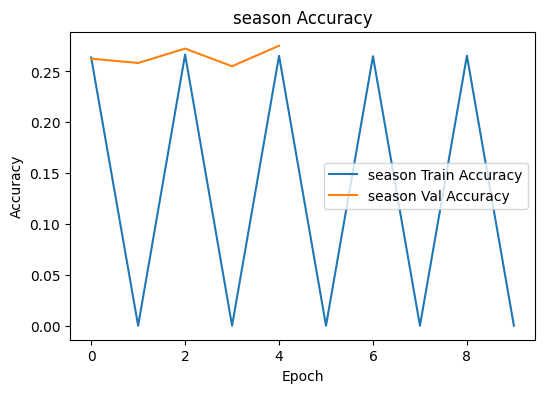

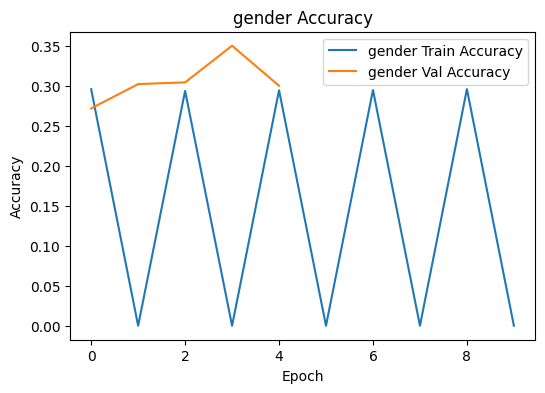

In [13]:
# Step 8: Evaluate the Model
# Plot training and validation accuracy for each task
for task in ['articleType', 'baseColour', 'season', 'gender']:
    plt.figure(figsize=(6, 4))
    plt.plot(history.history[f'{task}_accuracy'], label=f'{task} Train Accuracy')
    plt.plot(history.history[f'val_{task}_accuracy'], label=f'{task} Val Accuracy')
    plt.title(f'{task} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [14]:

# Step 9: Test the Model on New Images
# Load the saved model
from tensorflow.keras.models import load_model
model = load_model("fashion_product_model.h5")

# Function to preprocess and predict
def predict_fashion_product(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=img_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    predictions = model.predict(img_array)
    results = {}
    for i, task in enumerate(['articleType', 'baseColour', 'season', 'gender']):
        predicted_class = np.argmax(predictions[i])
        results[task] = label_encoders[task].inverse_transform([predicted_class])[0]
    return results

# Test on a sample image
sample_image_path = "/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/10001.jpg"  # Replace with your image path
results = predict_fashion_product(sample_image_path)
print("Predicted Results:")
print(results)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted Results:
{'articleType': 'Skirts', 'baseColour': 'Blue', 'season': nan, 'gender': 'Men'}


'\nimport streamlit as st\nfrom PIL import Image\nimport numpy as np\nfrom tensorflow.keras.models import load_model\n\n# Load the model\nmodel = load_model("fashion_product_model.h5")\n\n# Streamlit app\nst.title("Fashion Product Classifier")\nuploaded_file = st.file_uploader("Upload an image", type=["jpg", "jpeg", "png"])\n\nif uploaded_file is not None:\n    image = Image.open(uploaded_file)\n    st.image(image, caption=\'Uploaded Image\', use_column_width=True)\n    st.write("Classifying...")\n    \n    # Preprocess and predict\n    img_array = np.array(image.resize((224, 224))) / 255.0\n    img_array = np.expand_dims(img_array, axis=0)\n    predictions = model.predict(img_array)\n    \n    results = {}\n    \n    for i, task in enumerate([\'articleType\', \'baseColour\', \'season\', \'gender\']):\n        predicted_class = np.argmax(predictions[i])\n        results[task] = label_encoders[task].inverse_transform([predicted_class])[0]\n    \n    st.write("Predicted Results:")\n    s

In [16]:
from IPython.display import FileLink

# Create a download link
FileLink("fashion_product_model.h5")

/kaggle/working/fashion_product_model.h5

In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import joblib

# Load the dataset
df = pd.read_csv("/kaggle/input/fashion-product-images-dataset/fashion-dataset/styles.csv", on_bad_lines='skip')

# Initialize LabelEncoders
label_encoders = {
    'articleType': LabelEncoder(),
    'baseColour': LabelEncoder(),
    'season': LabelEncoder(),
    'gender': LabelEncoder()
}

# Fit the LabelEncoders on the original data
label_encoders['articleType'].fit(df['articleType'])
label_encoders['baseColour'].fit(df['baseColour'])
label_encoders['season'].fit(df['season'])
label_encoders['gender'].fit(df['gender'])

# Save the LabelEncoders
joblib.dump(label_encoders, 'label_encoders.pkl')

['label_encoders.pkl']

In [3]:
from IPython.display import FileLink

# Create a download link
FileLink("label_encoders.pkl")

/kaggle/working/label_encoders.pkl